## Ryan Bubb's replication

NOTES:  
- Ran without error (after installing subtex and rotw).
- Does not use more recently available RDD Stata modules.
- the rotbw.ado file written by Ryan.  Here we try to replace with rdplot

In [1]:
clear
clear matrix
* set mem 1000m
set matsize 400
set more off
graph drop _all
pwd







G:\Opapers\replications\Bubb


In [2]:
%set user_graph_keywords vioplot,coefplot,rdplot --permanently 

#### Append Gahna and IC Datasets

In [3]:
use ghana8788.dta
gen ghana = 1

append using ic.dta

replace ghana = 0 if ghana == .
label define ghanalabel 0 "CI" 1 "Ghana"
label values ghana ghanalabel




(note: variable regionname was str4, now str13 to accommodate using data's values)
(label region already defined)
(label V97 already defined)
(label V96 already defined)
(label V95 already defined)
(label V94 already defined)
(label V90 already defined)
(label V89 already defined)
(label V88 already defined)
(label V87 already defined)
(label V86 already defined)
(label V85 already defined)
(label V83 already defined)
(label V82 already defined)
(label V81 already defined)
(label V80 already defined)
(label LABE already defined)
(label V78 already defined)
(label V76 already defined)
(label LABD already defined)
(label V74 already defined)
(label V73 already defined)
(label V72 already defined)
(label V71 already defined)
(label V70 already defined)
(label V69 already defined)
(label V68 already defined)
(label V67 already defined)
(label V66 already defined)
(label LABC already defined)
(label LABB already defined)
(label V44 already defined)
(label V43 already defined)
(label V42 

In [4]:
* -----------------------------------------
* DECLARE SURVEY STRUCTURE OF THE DATA
* -----------------------------------------

* because CI data has to be weighted but GLSS data is self-weighting, need to create
* a weighting variable for the Ghana data so that I can svyset it all at once.

replace allwaitn = 1 if ghana == 1

* In CILSS, strata are regionname (Abidjan East Forst, West Forest, Savanna, Other Cities)
* In GLSS, strata are ecozone crossed with urban / semiurban / rural.

egen ghanastrata = concat(ecozonename clusttype) if ghana == 1

* create one strata variable to hold the appropriate strata for each country
gen strata = ghanastrata
replace strata=regionname if ghana == 0

* declare sampling structure of the survey data
svyset clust [pweight=allwaitn], strata(strata)

sort ghana


(4,826 real changes made)

(4062 missing values generated)

(4,062 missing values generated)

variable strata was str2 now str12
(4,062 real changes made)


      pweight: allwaitn
          VCE: linearized
  Single unit: missing
     Strata 1: strata
         SU 1: clust
        FPC 1: <zero>



In [5]:
tab ghana


      ghana |      Freq.     Percent        Cum.
------------+-----------------------------------
         CI |      4,062       45.70       45.70
      Ghana |      4,826       54.30      100.00
------------+-----------------------------------
      Total |      8,888      100.00


In [6]:
*-----------------
* CLEAN DATA
*------------------
*Remove negative values for landcultamt and netcultamt

codebook landcultamt landownedamt

list landcultamt landownedamt landrentoutamt12mos landrentinamt12mos if landcultamt < 0



---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
landcultamt                                                                                                                                                                                                                       Land cultivated by HH (acres)
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

                  type:  numeric (float)

                 range:  [-121786,2850]               units:  1.000e-08
         unique values:  188                      missing .:  6,327/8,888

                  mean:  -4.68856
      

In [7]:
* this is one strange outlier that I'm just going to drop.
drop if landrentoutamt12mos > 100000 & landrentoutamt12mos != .

* for those who claim to rent out more land than they own, set cultivation amount to 0
replace landcultamt = 0 if landcultamt < 0


(1 observation deleted)

(9 real changes made)


In [8]:
* ---------------------
* LABEL VARIABLES
* --------------------------
* helps clean up output
label variable ghana "Ghana"
label variable rightrentoutlandany "Right to rent out land" 
label variable rightselllandany  "Right to sell land"
label variable paidrentout  "Rented out land in last 12 mos."
label variable landsoldany12mos "Sold land in last 12 mos."
label variable paidrentin "Rented in land in last 12 mos."
label variable  migrant "Migrant"
label variable  coffeeany12mos "Grows coffee"
label variable  schhead "Household head attended school"
label variable readhead "Household head literate"
label variable arithhead "Household head numerate"
label variable borderdist "Distance to border"

?? note below using svy but no svset command yet.

In [9]:
* --------------------------------------------
* MORE GENERAL DESCRIPTIVE ANALYSIS
* --------------------------------------------

* What type of households are more likely to have rights to sell their land?


* HHs that rent in all of the land they use.  Note: have to check this before trimming sample
* to HHs who own agricultural land.
svy: reg rightrentoutlandany onlyrentsland
svy: reg rightselllandany onlyrentsland


(running regress on estimation sample)

Survey: Linear regression

Number of strata   =        14                  Number of obs     =      5,675
Number of PSUs     =       419                  Population size   = 5,743.4582
                                                Design df         =        405
                                                F(   1,    405)   =     474.60
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0754

-------------------------------------------------------------------------------
              |             Linearized
rightrentou~y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
--------------+----------------------------------------------------------------
onlyrentsland |  -.4232978   .0194304   -21.79   0.000    -.4614948   -.3851008
        _cons |    .500826   .0130185    38.47   0.000     .4752336    .5264183
------------------

In [10]:
* TABLE X
* Produce pairwise correlations among the land rights variables
pwcorr rightrentoutlandany rightselllandany paidrentout fracfallow if ownsland == 1, sig obs


             | rightr~y rights~y paidre~t fracfa~w
-------------+------------------------------------
rightrento~y |   1.0000 
             |
             |     4916
             |
rightselll~y |   0.4328   1.0000 
             |   0.0000
             |     4815     4818
             |
 paidrentout |   0.3343   0.2116   1.0000 
             |   0.0000   0.0000
             |     4913     4813     4914
             |
  fracfallow |   0.1860   0.1792   0.0434   1.0000 
             |   0.0000   0.0000   0.0023
             |     4916     4818     4914     4919
             |


In [11]:
* create some vars
gen cocoaorcoffeeany12mos = max(coffeeany12mos, cocoaany12mos)
gen loghhsize = log(hhsize)
gen loglandownedamt = log(landownedamt)

gen exppercap = realtotalexp / hhsize
gen logexppercap = log(exppercap)

gen malehead = .
replace malehead = 1 if sexhead==1
replace malehead = 0 if sexhead==2

gen logageyhead = log(ageyhead)

* generate value of land variable
* In ghana, we know the value of land owned (both cultivated and fallow) by the HH.
gen valueland = landownedv if ghana == 1

* In CI, we know the value of land cultivated by the HH:
replace valueland = landcultv if ghana == 0

* create per unit measure.  In Ghana it is acres.  In CI it is hectares.  And note different denom.
gen valuelandperunit = landownedvperacre if ghana == 1
replace valuelandperunit = landcultvperhect if ghana == 0

gen logvalueland = log(valueland)
gen logvaluelandperunit = log(valuelandperunit)

svyset clust [pweight=allwaitn]

preserve 

keep if ownsland == 1 



(16 missing values generated)

(3,968 missing values generated)

(53 missing values generated)

(53 missing values generated)

(8,887 missing values generated)

(7,043 real changes made)

(1,828 real changes made)

(16 missing values generated)

(6,463 missing values generated)

(2,441 real changes made)

(6,489 missing values generated)

(2,390 real changes made)

(4,609 missing values generated)

(4,655 missing values generated)


      pweight: allwaitn
          VCE: linearized
  Single unit: missing
     Strata 1: <one>
         SU 1: clust
        FPC 1: <zero>


(3,968 observations deleted)


In [12]:
* TABLE Y
* Regress rights measures on hh characteristics, GH and CI separately,
*  with and without EA fixed effects
svy: reg rightrentoutlandany loglandownedamt logvalueland cocoaorcoffeeany12mos ///
         malehead ageyhead schhead migrant hhsize  logexppercap i.clust if ghana == 1
        
svy: reg rightselllandany loglandownedamt logvalueland cocoaorcoffeeany12mos ///
         malehead ageyhead schhead migrant hhsize  logexppercap i.clust if ghana == 1        

svy: reg rightrentoutlandany loglandownedamt logvalueland cocoaorcoffeeany12mos ///
         malehead ageyhead schhead migrant hhsize  logexppercap i.clust if ghana == 0
        
svy: reg rightselllandany loglandownedamt logvalueland cocoaorcoffeeany12mos ///
         malehead ageyhead schhead migrant hhsize  logexppercap i.clust if ghana == 0 
    
  
restore


(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =      1,828
Number of PSUs     =       223                  Population size   =      1,828
                                                Design df         =        222
                                                F(   9,    214)   =          .
                                                Prob > F          =          .
                                                R-squared         =     0.3769

---------------------------------------------------------------------------------------
                      |             Linearized
  rightrentoutlandany |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
----------------------+----------------------------------------------------------------
      loglandownedamt |   .0923404   .0166862     5.53   0.000     .0594569    .1252239
         logvalueland |   .0261429   .0097807     2.67   0

                1103  |  -.4885862   .0383314   -12.75   0.000    -.5641261   -.4130463
                1104  |  -.4902395   .0413954   -11.84   0.000    -.5718177   -.4086612
                1105  |  -.7465798   .0701095   -10.65   0.000    -.8847451   -.6084145
                1107  |  -.7814671   .0778729   -10.04   0.000    -.9349318   -.6280024
                1108  |   -.912802   .0696696   -13.10   0.000      -1.0501   -.7755035
                1109  |  -.6284796   .0635348    -9.89   0.000    -.7536881   -.5032712
                1111  |  -.5292816   .0444258   -11.91   0.000    -.6168319   -.4417314
                1112  |  -.7526215   .0544579   -13.82   0.000    -.8599421   -.6453009
                1113  |  -.5987462    .066228    -9.04   0.000    -.7292621   -.4682303
                1114  |  -.8378699     .05843   -14.34   0.000    -.9530183   -.7227215
                1115  |  -.7162074   .0622771   -11.50   0.000    -.8389373   -.5934775
                1117  |  -.10659

                2222  |  -.5432279   .0626076    -8.68   0.000    -.6666092   -.4198467
                2230  |  -.9213047   .0413937   -22.26   0.000     -1.00288   -.8397297
                2262  |  -.3366597   .0463017    -7.27   0.000    -.4279067   -.2454127
                2286  |  -.4925736   .0490765   -10.04   0.000     -.589289   -.3958583
                2294  |  -.8430972   .0600151   -14.05   0.000    -.9613695   -.7248249
                2302  |  -.6863451   .0718705    -9.55   0.000    -.8279808   -.5447094
                2310  |  -.6781366   .0651998   -10.40   0.000    -.8066264   -.5496469
                2318  |  -.3712356   .0501414    -7.40   0.000    -.4700497   -.2724215
                2326  |   -.543714   .0691022    -7.87   0.000    -.6798943   -.4075337
                2334  |  -.5800069     .05234   -11.08   0.000    -.6831537   -.4768601
                2342  |  -.2001966   .0515938    -3.88   0.000    -.3018729   -.0985202
                2350  |  -.35711

                1025  |   .1467134   .0358478     4.09   0.000     .0760695    .2173573
                1026  |   .0269667   .0410113     0.66   0.512    -.0538526    .1077859
                1028  |   .1993082   .0306843     6.50   0.000     .1388399    .2597765
                1029  |   .0971004   .0508032     1.91   0.057    -.0030154    .1972162
                1030  |   .1268484   .0248694     5.10   0.000     .0778393    .1758575
                1031  |   .1722955   .0296195     5.82   0.000     .1139256    .2306655
                1032  |   .4186692   .0312908    13.38   0.000     .3570057    .4803327
                1033  |  -.1445227    .049171    -2.94   0.004    -.2414219   -.0476234
                1035  |   .2991955   .0468205     6.39   0.000     .2069284    .3914627
                1037  |   .2428847   .0482966     5.03   0.000     .1477086    .3380608
                1038  |  -.0074498   .0498235    -0.15   0.881    -.1056349    .0907354
                1041  |   .13054

                1150  |   .3060265   .0307803     9.94   0.000      .245369     .366684
                1151  |   .3021667   .0240033    12.59   0.000     .2548643     .349469
                1153  |     .64404   .0291215    22.12   0.000     .5866515    .7014285
                1155  |   .2289223   .0352158     6.50   0.000      .159524    .2983206
                1156  |   .6075695   .0337522    18.00   0.000     .5410555    .6740835
                1157  |   .4468409   .0280842    15.91   0.000     .3914965    .5021852
                1158  |   .0634902   .0522633     1.21   0.226     -.039503    .1664833
                1159  |   .8640858   .0337577    25.60   0.000     .7975608    .9306108
                1160  |   .1056654   .0533614     1.98   0.049     .0005083    .2108226
                1161  |  -.0408791   .0471694    -0.87   0.387     -.133834    .0520757
                1162  |   .6729154   .0374312    17.98   0.000     .5991512    .7466796
                1163  |   .56276

                2606  |   .6251191   .0461441    13.55   0.000     .5341849    .7160533
                2614  |   1.084645   .0336908    32.19   0.000     1.018252    1.151038
                2622  |   .3350701   .0440771     7.60   0.000     .2482092    .4219311
                2638  |   .1562129    .061672     2.53   0.012     .0346785    .2777474
                2646  |   .2664241   .0585623     4.55   0.000     .1510178    .3818304
                2654  |   .1772883   .0539636     3.29   0.001     .0709445    .2836322
                2662  |   .1981732    .049432     4.01   0.000     .1007597    .2955868
                2670  |  -.0995308   .0664177    -1.50   0.135    -.2304174    .0313559
                2678  |   .1057803   .0645247     1.64   0.103    -.0213759    .2329364
                2686  |   .1063686    .141393     0.75   0.453    -.1722687     .385006
                2694  |   .7186914    .069281    10.37   0.000     .5821621    .8552206
                2718  |   .89376

                  71  |   .0183466   .0582269     0.32   0.753    -.0966512    .1333445
                  72  |   .3818825    .052446     7.28   0.000     .2783018    .4854632
                  73  |   .1548746   .0436415     3.55   0.001     .0686828    .2410663
                  74  |   .0046316   .0451471     0.10   0.918    -.0845338     .093797
                  75  |  -.0516565    .043988    -1.17   0.242    -.1385327    .0352197
                  76  |   .2526349   .0614002     4.11   0.000     .1313698       .3739
                  77  |   .0996361   .0606126     1.64   0.102    -.0200735    .2193457
                  78  |   .2381417   .0625407     3.81   0.000     .1146242    .3616593
                  79  |  -.1891015   .0578581    -3.27   0.001     -.303371    -.074832
                  80  |   .5347663   .0601238     8.89   0.000      .416022    .6535107
                  81  |   .0127724    .048701     0.26   0.793    -.0834118    .1089567
                  82  |   .16628

                 191  |   .2859631   .0515285     5.55   0.000     .1841944    .3877317
                 192  |   .3318861   .0571583     5.81   0.000     .2189987    .4447735
                 193  |   .3184382   .0477471     6.67   0.000     .2241379    .4127384
                 194  |   .1041782   .0478088     2.18   0.031     .0097561    .1986004
                 195  |   .4144763   .0439272     9.44   0.000     .3277203    .5012323
                 196  |   .0623463   .0494277     1.26   0.209    -.0352731    .1599657
                 197  |   .1647136   .0446962     3.69   0.000     .0764389    .2529883
                 198  |   .2782283   .0595905     4.67   0.000     .1605374    .3959193
                 199  |   .0796681   .0491333     1.62   0.107    -.0173699    .1767061
                 200  |   .3414177   .0530263     6.44   0.000      .236691    .4461444
                      |
                _cons |   .3119098   .3011084     1.04   0.302    -.2827781    .9065977
--------

                  78  |  -.3907296    .050584    -7.72   0.000    -.4906329   -.2908263
                  79  |  -.3863021   .0502373    -7.69   0.000    -.4855205   -.2870836
                  80  |  -.3562739   .0497576    -7.16   0.000    -.4545449   -.2580029
                  81  |  -.3212667   .0411877    -7.80   0.000    -.4026122   -.2399212
                  82  |  -.1734106   .0507724    -3.42   0.001    -.2736858   -.0731353
                  83  |  -.4175224   .0492785    -8.47   0.000    -.5148472   -.3201976
                  84  |  -.2210706   .0587795    -3.76   0.000    -.3371598   -.1049814
                  85  |   .4498877    .044716    10.06   0.000     .3615737    .5382016
                  86  |   .4803413   .0399708    12.02   0.000     .4013991    .5592834
                  87  |   .2546634   .0424366     6.00   0.000     .1708513    .3384755
                  88  |   .3613177    .033875    10.67   0.000     .2944147    .4282208
                  89  |  -.43735

                 198  |   .5311537   .0504009    10.54   0.000     .4316122    .6306952
                 199  |   .4598058    .041933    10.97   0.000     .3769882    .5426234
                 200  |   .4457096   .0444108    10.04   0.000     .3579984    .5334208
                      |
                _cons |   .1754246   .2651378     0.66   0.509    -.3482216    .6990708
---------------------------------------------------------------------------------------



In [13]:
 * Check fraction of HHs in Ghana that moved from CI, and in CI that moved from Ghana
gen movedfromghana = 0
replace movedfromghana = 1 if deptmovhead == 39

gen movedfromci = 0
replace movedfromci = 1 if regmovhead == 12

gen movedfromcighana = movedfromci
replace movedfromcighana = 1 if movedfromghana == 1

preserve
keep if ownsland==1



(35 real changes made)


(57 real changes made)


(35 real changes made)


(3,968 observations deleted)


In [14]:
* --------------------------------
* SAMPLE DESCRIPTIVE STATS TABLE
* --------------------------------
    
sum ghana rightrentoutlandany rightselllandany paidrentout  landsoldany12mos fracfallow /// 
    landownedamt valueland coffeeany12mos cocoaany12mos cocoaorcoffeeany12mos ///
    clustfraccocoaland cocoasuitindex malehead ageyhead schhead readhead arithhead ///
    migrant movedfromcighana borderdist
    
sutex ghana rightrentoutlandany rightselllandany paidrentout  landsoldany12mos fracfallow /// 
    landownedamt valueland coffeeany12mos cocoaany12mos cocoaorcoffeeany12mos ///
    clustfraccocoaland cocoasuitindex malehead ageyhead schhead readhead arithhead ///
    migrant movedfromcighana borderdist, ///
    key("tab:descripstat") labels placement(p) title("Sample Descriptive Statistics")


* save analysis dataset
save analysissample.dta, replace

restore



    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
       ghana |      4,919     .571051    .4949763          0          1
rightrento~y |      4,916    .5081367    .4999846          0          1
rightselll~y |      4,818    .3107098    .4628323          0          1
 paidrentout |      4,914    .1033781    .3044831          0          1
landsoldan~s |      3,734     .006963     .083165          0          1
-------------+---------------------------------------------------------
  fracfallow |      4,919     .296767    .2779069          0          1
landownedamt |      4,919    40.44304    100.5425         .1       3250
   valueland |      4,503     4042829    3.86e+07          0   1.00e+09
coffeeany1~s |      4,919    .2047164    .4035353          0          1
cocoaany12~s |      4,919    .3470218    .4760711          0          1
-------------+------------------------------------------------

In [15]:
* --------------------------------
* COMPARE GHANA TO COTE D'IVOIRE TABLE
* --------------------------------

preserve
keep if ownsland==1
svyset clust [pweight=allwaitn], strata(strata)

foreach var of varlist rightrentoutlandany rightselllandany paidrentout fracfallow landsoldany12mos ///
                       paidrentin cocoaany12mos coffeeany12mos cocoaorcoffeeany12mos migrant schhead readhead arithhead ///
                       malehead ageyhead ghanaianhead ivorianhead borderdist movedfromcighana {
svy: mean `var', over(ghana)
svy: reg `var' ghana
}
restore

* Question: Does it matter whether I renormalize the weights for CI?  They were normalized over
* the entire CLSS sample, but I've selected on a particular sample here.  Let's renormalize to find
* out.

* ANSWER: I investigated this and renormalizing the weights makes no difference.  The reason is that
* Stata automatically normalizes pweights.



(3,968 observations deleted)


      pweight: allwaitn
          VCE: linearized
  Single unit: missing
     Strata 1: strata
         SU 1: clust
        FPC 1: <zero>

(running mean on estimation sample)

Survey: Mean estimation

Number of strata =      14        Number of obs   =      4,916
Number of PSUs   =     408        Population size = 4,974.4941
                                  Design df       =        394

           CI: ghana = CI
        Ghana: ghana = Ghana

---------------------------------------------------------------------
                    |             Linearized
               Over |       Mean   Std. Err.     [95% Conf. Interval]
--------------------+------------------------------------------------
rightrentoutlandany |
                 CI |   .6687851   .0192956      .6308498    .7067203
              Ghana |   .3809694   .0163032      .3489172    .4130215
---------------------------------------------------------------------
(running regress on estimation sa

(running regress on estimation sample)

Survey: Linear regression

Number of strata   =        14                  Number of obs     =      3,734
Number of PSUs     =       375                  Population size   =  3,767.622
                                                Design df         =        361
                                                F(   1,    361)   =       2.21
                                                Prob > F          =     0.1383
                                                R-squared         =     0.0004

------------------------------------------------------------------------------
             |             Linearized
landsoldan~s |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ghana |   .0039486   .0026585     1.49   0.138    -.0012794    .0091766
       _cons |   .0038862   .0019725     1.97   0.050     7.11e-06    .0077652
-------------------------

------------------------------------------------------------------------------
(running mean on estimation sample)

Survey: Mean estimation

Number of strata =      14        Number of obs   =      4,915
Number of PSUs   =     409        Population size = 4,973.4941
                                  Design df       =        395

           CI: ghana = CI
        Ghana: ghana = Ghana

--------------------------------------------------------------
             |             Linearized
        Over |       Mean   Std. Err.     [95% Conf. Interval]
-------------+------------------------------------------------
migrant      |
          CI |   .2700019   .0228712      .2250374    .3149664
       Ghana |   .4545455   .0202912      .4146533    .4944377
--------------------------------------------------------------
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =        14                  Number of obs     =      4,915
Number of PSUs     =       409      

                                                Design df         =        395
                                                F(   1,    395)   =     162.48
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0725

------------------------------------------------------------------------------
             |             Linearized
    malehead |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ghana |  -.2094904   .0164347   -12.75   0.000    -.2418008   -.1771801
       _cons |    .936245   .0088533   105.75   0.000     .9188394    .9536505
------------------------------------------------------------------------------
(running mean on estimation sample)

Survey: Mean estimation

Number of strata =      14        Number of obs   =      4,917
Number of PSUs   =     409        Population s


           CI: ghana = CI
        Ghana: ghana = Ghana

------------------------------------------------------------------
                 |             Linearized
            Over |       Mean   Std. Err.     [95% Conf. Interval]
-----------------+------------------------------------------------
movedfromcighana |
              CI |   .0051062   .0017983      .0015708    .0086415
           Ghana |    .009968    .001878      .0062758    .0136601
------------------------------------------------------------------
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =        14                  Number of obs     =      4,919
Number of PSUs     =       409                  Population size   = 4,977.4941
                                                Design df         =        395
                                                F(   1,    395)   =       3.50
                                                Prob > F          =     0.0622
                  

In [16]:
* ---------------------------------------------
* REGRESSION DISCONTINUITY ANALYSIS
* ----------------------------------------------


* include only the clusters below lat = 8.0 since there are no units above lat = 8.0 in IC near the border.
* before we do that, though, save off a dataset with all the observations. We need this to show, later on,
* that we can't do a RD analysis for cocoa growing regions and non-cocoa growing regions separately.

save data_all_lat.dta, replace
keep if lat <= 8.0

* create dist variable that is negative in CI
gen dist = borderdist
replace dist = -1*dist if ghana == 0

* create higher order terms
gen dist2 = dist^2
gen dist3 = dist^3
gen dist4 = dist^4
gen dist5 = dist^5

* create interaction terms
gen ghanadist = ghana*dist
gen ghanadist2 = ghana*dist2
gen ghanadist3 = ghana*dist3
gen ghanadist4 = ghana*dist4
gen ghanadist5 = ghana*dist5


gen lon2 = lon * lon
gen lat2 = lat * lat

* Population density in 1960.
gen logpop60 = log(pop60)
gen logpop90 = log(pop90)


* create "district" variable common to ghana and CI observations
gen admin_district = districtname
replace admin_district = subprefect_gis if ghana ==0

encode admin_district, generate(admin_district_id)

svyset clust [pweight=allwaitn]


file data_all_lat.dta saved

(1,254 observations deleted)

(193 missing values generated)

(3,478 real changes made)

(193 missing values generated)

(193 missing values generated)

(193 missing values generated)

(193 missing values generated)

(193 missing values generated)

(193 missing values generated)

(193 missing values generated)

(193 missing values generated)

(193 missing values generated)



(112 missing values generated)

(64 missing values generated)

(3,478 missing values generated)

(3,478 real changes made)



      pweight: allwaitn
          VCE: linearized
  Single unit: missing
     Strata 1: <one>
         SU 1: clust
        FPC 1: <zero>


In [17]:
summ dist


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
        dist |      7,440    12.03913    234.2842  -565.5129   423.7371


In [18]:
foreach var of varlist rightrentoutlandany rightselllandany paidrentout fracfallow landsoldany12mos ///
                       paidrentin cocoaany12mos coffeeany12mos cocoaorcoffeeany12mos migrant schhead readhead arithhead ///
                       malehead ageyhead ghanaianhead ivorianhead borderdist movedfromcighana {
display "`var'"
rotbw `var' dist
return list
}



rightrentoutlandany

scalars:
                r(rbw) =  176.3403606039672
                r(lbw) =  172.1924807320234
rightselllandany

scalars:
                r(rbw) =  96.19516562543075
                r(lbw) =  95.27065511309105
paidrentout

scalars:
                r(rbw) =  99.19258087874547
                r(lbw) =  98.18279446576432
fracfallow

scalars:
                r(rbw) =  67.1047098265319
                r(lbw) =  138.318081436485
landsoldany12mos

scalars:
                r(rbw) =  151.7620147147728
                r(lbw) =  134.4686610174028
paidrentin

scalars:
                r(rbw) =  95.21162774703431
                r(lbw) =  140.0632255979299
cocoaany12mos

scalars:
                r(rbw) =  173.1702722568625
                r(lbw) =  64.6191510367058
coffeeany12mos

scalars:
                r(rbw) =  93.84539811647385
                r(lbw) =  70.50105023306266
cocoaorcoffeeany12mos

scalars:
                r(rbw) =  173.5828905709519
                r(lbw) = 

In [19]:
rotbw rightrentoutlandany dist

In [27]:
rdrobust rightrentoutlandany dist p(4)


Sharp RD estimates using local polynomial regression.

      Cutoff c = 0 | Left of c  Right of c            Number of obs =       3964
-------------------+----------------------            BW type       =      mserd
     Number of obs |      1672        2292            Kernel        = Triangular
Eff. Number of obs |       465         616            VCE method    =         NN
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |   117.379     117.379
       BW bias (b) |   169.084     169.084
         rho (h/b) |     0.694       0.694

Outcome: rightrentoutlandany. Running variable: dist.
--------------------------------------------------------------------------------
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval]
-------------------+------------------------------------------------------------
      Conventional | -.02574     .06573   -0.3915  0.695   -.154562       .10309
            Robust |     -

Note the following rdplot is pretty much the same as Ryan publishes (number or bins displayed only differs but polynomial has same shape).


RD Plot with evenly spaced mimicking variance number of bins using spacings estimators.

         Cutoff c = 0 | Left of c  Right of c        Number of obs  =       3964
----------------------+----------------------        Kernel         =    Uniform
        Number of obs |      1672        2292
   Eff. Number of obs |      1672        2292
  Order poly. fit (p) |         4           4
     BW poly. fit (h) |   565.513     423.737
 Number of bins scale |     1.000       1.000

Outcome: rightrentoutlandany. Running variable: dist.
---------------------------------------------
                      | Left of c  Right of c
----------------------+----------------------
        Bins selected |        69          73
   Average bin length |     8.196       5.805
    Median bin length |     8.196       5.805
----------------------+----------------------
    IMSE-optimal bins |         6           7
  Mimicking Var. bins |        69          73
----------------------+----------------------
Rel

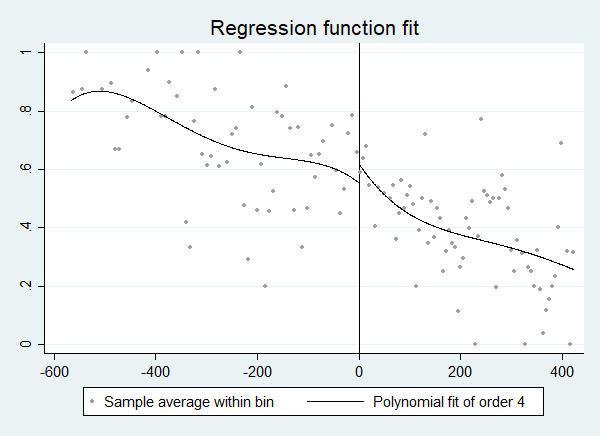

In [30]:
rdplot rightrentoutlandany dist, p(4)  weights(allwaitn) 

In [21]:
set more off 
local depvars lat rightrentoutlandany rightselllandany  paidrentout fracfallow ///
		schhead readhead arithhead movedfromcighana migrant ///
		cocoaany12mos coffeeany12mos cocoaorcoffeeany12mos 
		
local binarydepvars  rightrentoutlandany rightselllandany  paidrentout fracfallow ///
		schhead readhead arithhead movedfromcighana migrant ///
		cocoaany12mos coffeeany12mos cocoaorcoffeeany12mos                   

local lat_title "{stSerif:Latitude}" 
local rightrentoutlandany_title "{stSerif:Right to rent out land}"
local rightselllandany_title "{stSerif:Right to sell land}"
local paidrentout_title "{stSerif:Rented out land in last 12 mos.}"
local fracfallow_title "{stSerif:Fraction of land fallowed}"
local schhead_title "{stSerif:Household head attended school}"
local readhead_title "{stSerif:Household head is literate}"
local arithhead_title "{stSerif:Household head is numerate}"
local movedfromcighana_title "{stSerif:Household head moved between CI and Ghana}"
local migrant_title "{stSerif:Household head born elsewhere}"
local cocoaany12mos_title "{stSerif:Grows cocoa}"
local coffeeany12mos_title "{stSerif:Grows coffee}"
local cocoaorcoffeeany12mos_title "{stSerif:Grows cocoa or coffee}"

In [22]:
foreach var of local binarydepvars {

	local `var'_ticks "0(0.1)1"
}


* the current dataset includes households who rent in all of their land.  
* save this dataset off before dropping those who do not own any of their land 
* so that I can reopen it to do robustness check keeping those who do not own
* their land.
save samplewithtenantfarmers.dta, replace

keep if ownsland==1

save samplewithouttenantfarmers.dta, replace



file samplewithtenantfarmers.dta saved

(3,666 observations deleted)

file samplewithouttenantfarmers.dta saved


In [23]:
* create bins within which to calculate local averages
local binsize = 15
gen distbin = dist / `binsize'
replace distbin = floor(distbin) 
* center bins at midpoint
replace distbin = distbin * `binsize' + `binsize'/2

* to make scatter plots prettier, create a marker for one household in each bin
sort distbin
by distbin: egen minhid = min(hid)
gen binmarker = 0
replace binmarker = 1 if hid == minhid

* to make fitted plots prettier, create a marker for one household in each cluster
sort clust
by clust: egen clustminhid = min(hid)
gen clustmarker = 0
replace clustmarker = 1 if hid == clustminhid




(3,967 real changes made)

(3,967 real changes made)




(65 real changes made)




(349 real changes made)




 11.  scalar tval = invttail(e(df_r), 0.975)
 12.  gen polyfit_u = polyfit + tval*polystd
 13.  gen polyfit_l = polyfit - tval*polystd
 14.  sort dist
 15. cap noi  twoway scatter binavg distbin if binmarker==1 & ghana == 0, mcolor(black)      || scatter binavg distbin if binmarker==1 & ghana == 1, msymbol(Oh) mcolor(black) xline(0, lpattern(line) lcolor(black))      || line polyfit dist if ghana == 0 &
>  clustmarker == 1,  lwidth(medthick) lcolor(black)       || line polyfit dist if ghana == 1 & clustmarker == 1,  lwidth(medthick) lcolor(black)       xtitle("{stSerif:Distance to border}") ytitle( ``var'_title' ) ylabel(``var'_ticks', grid)       legend
> (off) scheme(s1color) 
 16. if _rc == 0 {
 17.     noi gr export C:/Users/jconning/.stata_kernel_cache/graph$stata_kernel_graph_counter.png, width(600) replace
 18.     global stata_kernel_graph_counter = $stata_kernel_graph_counter + 1
 19. }            
 20.  graph export rd`var'.pdf, replace
 21.  rotbw `var' dist
 22.  local hl

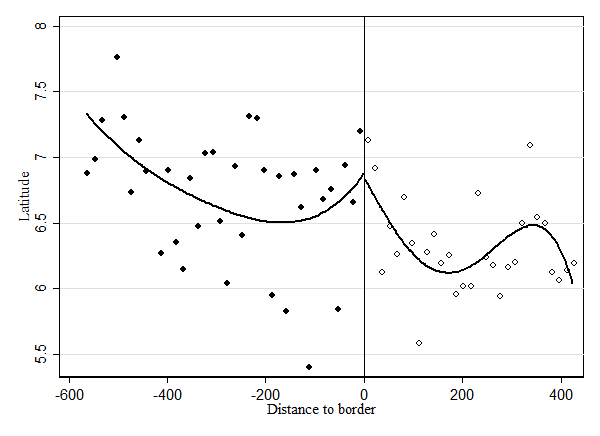


(file rdlat.pdf written in PDF format)
113.24831
79.954143
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =        869
Number of PSUs     =        70                  Population size   = 858.171838
                                                Design df         =         69
                                                F(   3,     67)   =       1.10
                                                Prob > F          =     0.3561
                                                R-squared         =     0.0481

------------------------------------------------------------------------------
             |             Linearized
         lat |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ghana |  -.0088938    .426907    -0.02   0.983    -.8605499    .8427623
        dist |   .0049418   .0040683     1.2

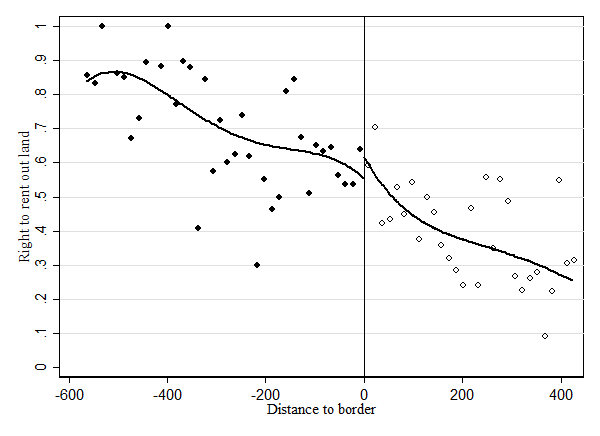


(file rdrightrentoutlandany.pdf written in PDF format)
174.85394
156.94768
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =      1,582
Number of PSUs     =       131                  Population size   = 1,576.8633
                                                Design df         =        130
                                                F(   3,    128)   =       5.59
                                                Prob > F          =     0.0012
                                                R-squared         =     0.0258

------------------------------------------------------------------------------
             |             Linearized
rightrento~y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ghana |   .0096972    .083159     0.12   0.907    -.1548229    .1742174
        dist |  -.0010105   

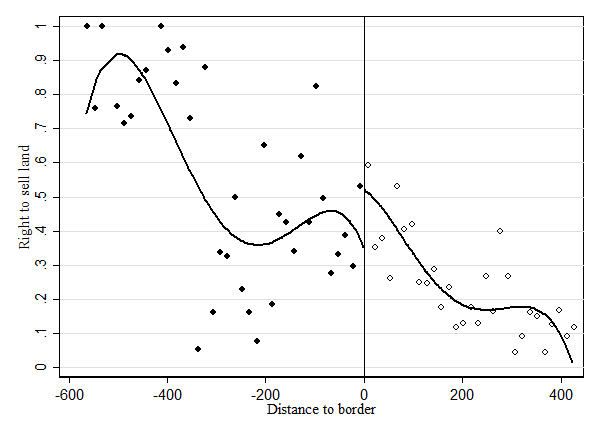


(file rdrightselllandany.pdf written in PDF format)
94.521321
101.88282
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =        982
Number of PSUs     =        72                  Population size   = 973.893829
                                                Design df         =         71
                                                F(   3,     69)   =       0.73
                                                Prob > F          =     0.5385
                                                R-squared         =     0.0095

------------------------------------------------------------------------------
             |             Linearized
rightselll~y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ghana |    .174369   .1217649     1.43   0.157    -.0684233    .4171613
        dist |  -.0024665   .00

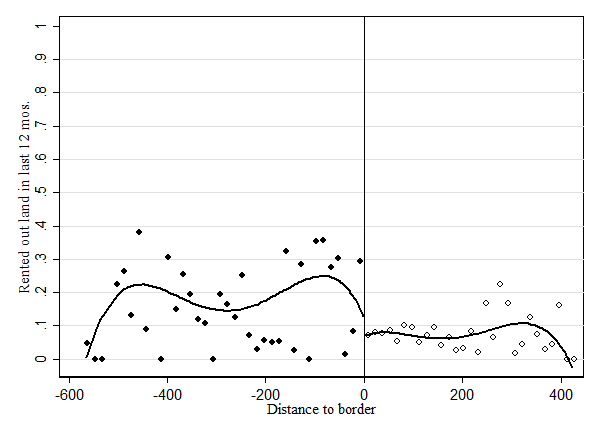


(file rdpaidrentout.pdf written in PDF format)
103.97113
99.405437
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =        979
Number of PSUs     =        69                  Population size   = 970.893829
                                                Design df         =         68
                                                F(   3,     66)   =       5.10
                                                Prob > F          =     0.0031
                                                R-squared         =     0.0668

------------------------------------------------------------------------------
             |             Linearized
 paidrentout |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ghana |  -.0395373   .0979513    -0.40   0.688    -.2349961    .1559216
        dist |  -.0026449   .0016678

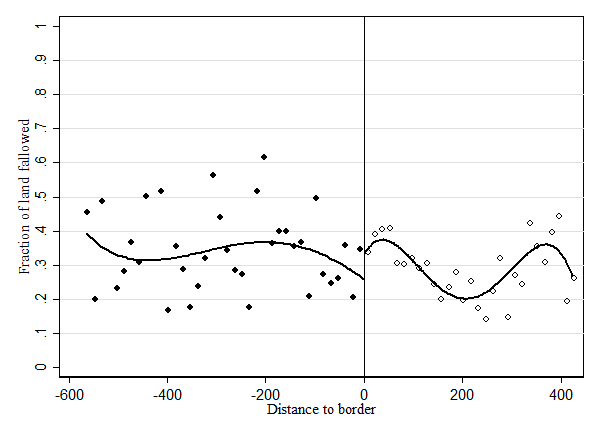


(file rdfracfallow.pdf written in PDF format)
160.72648
72.715617
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =      1,009
Number of PSUs     =        81                  Population size   = 1,000.9873
                                                Design df         =         80
                                                F(   3,     78)   =       2.26
                                                Prob > F          =     0.0884
                                                R-squared         =     0.0223

------------------------------------------------------------------------------
             |             Linearized
  fracfallow |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ghana |   .1375477   .0646795     2.13   0.037     .0088314    .2662641
        dist |  -.0009064   .0003879 

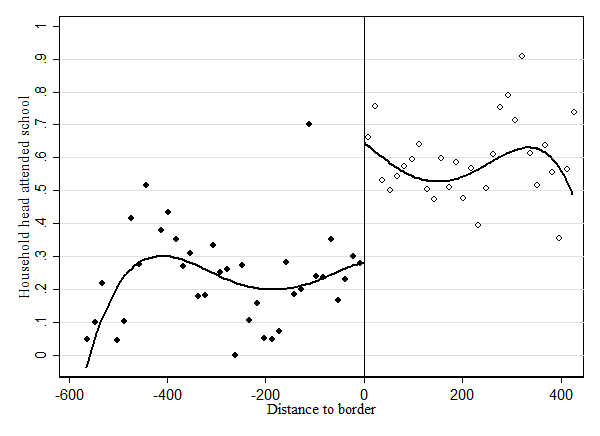


(file rdschhead.pdf written in PDF format)
124.51961
116.10541
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =      1,109
Number of PSUs     =        91                  Population size   = 1,096.2446
                                                Design df         =         90
                                                F(   3,     88)   =      27.03
                                                Prob > F          =     0.0000
                                                R-squared         =     0.1130

------------------------------------------------------------------------------
             |             Linearized
     schhead |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ghana |   .3254863   .0850654     3.83   0.000      .156489    .4944836
        dist |   .0000972   .0011743    

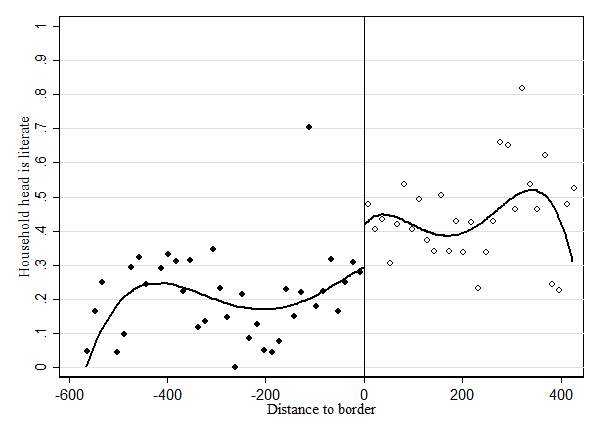


(file rdreadhead.pdf written in PDF format)
133.54422
93.916807
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =      1,013
Number of PSUs     =        83                  Population size   = 1,007.3926
                                                Design df         =         82
                                                F(   3,     80)   =       7.37
                                                Prob > F          =     0.0002
                                                R-squared         =     0.0361

------------------------------------------------------------------------------
             |             Linearized
    readhead |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ghana |   .1649871   .0761294     2.17   0.033     .0135415    .3164327
        dist |   .0000761   .0008157   

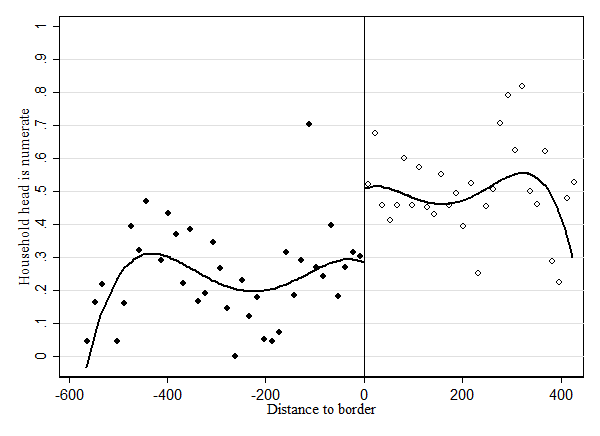


(file rdarithhead.pdf written in PDF format)
111.66404
99.258559
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =        997
Number of PSUs     =        80                  Population size   = 986.171838
                                                Design df         =         79
                                                F(   3,     77)   =       8.59
                                                Prob > F          =     0.0001
                                                R-squared         =     0.0436

------------------------------------------------------------------------------
             |             Linearized
   arithhead |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ghana |   .2613808   .0832901     3.14   0.002      .095596    .4271657
        dist |  -.0008582   .0011688  

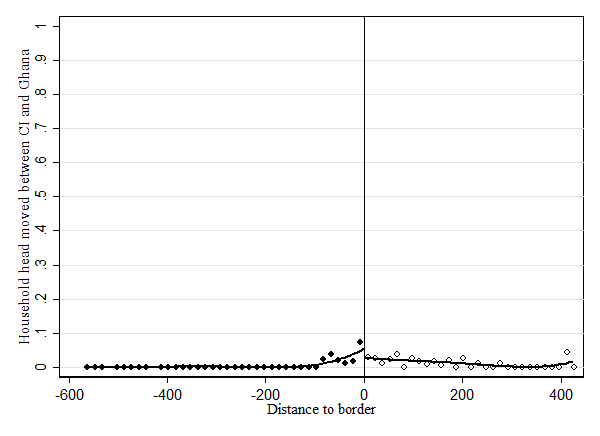


(file rdmovedfromcighana.pdf written in PDF format)
141.68959
152.98355
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =      1,436
Number of PSUs     =       120                  Population size   = 1,436.5458
                                                Design df         =        119
                                                F(   3,    117)   =       2.14
                                                Prob > F          =     0.0991
                                                R-squared         =     0.0048

------------------------------------------------------------------------------
             |             Linearized
movedfromc~a |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ghana |  -.0162331   .0214664    -0.76   0.451    -.0587388    .0262726
        dist |   .0003577   .00

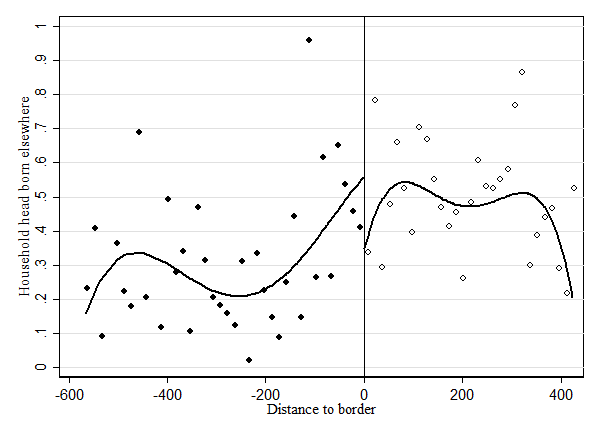


(file rdmigrant.pdf written in PDF format)
132.83276
80.37833
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =        928
Number of PSUs     =        75                  Population size   = 921.355572
                                                Design df         =         74
                                                F(   3,     72)   =       1.79
                                                Prob > F          =     0.1562
                                                R-squared         =     0.0280

------------------------------------------------------------------------------
             |             Linearized
     migrant |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ghana |  -.2431086   .1489891    -1.63   0.107    -.5399758    .0537586
        dist |    .002022   .0012575     

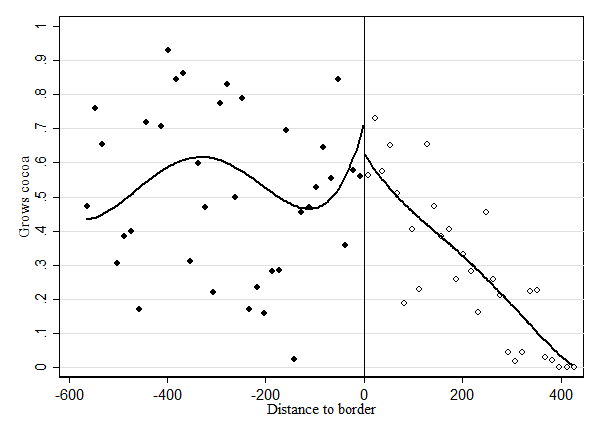


(file rdcocoaany12mos.pdf written in PDF format)
123.4803
178.32983
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =      1,622
Number of PSUs     =       140                  Population size   = 1,609.2446
                                                Design df         =        139
                                                F(   3,    137)   =       1.89
                                                Prob > F          =     0.1343
                                                R-squared         =     0.0186

------------------------------------------------------------------------------
             |             Linearized
cocoaany12~s |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ghana |  -.0688098   .1379962    -0.50   0.619    -.3416529    .2040333
        dist |   .0017439   .001923

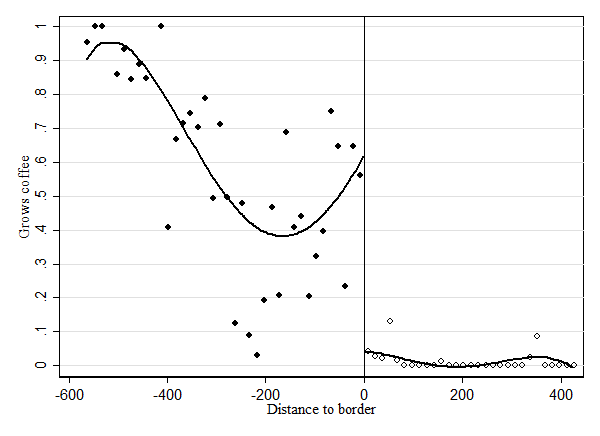


(file rdcoffeeany12mos.pdf written in PDF format)
123.09985
97.841507
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =      1,012
Number of PSUs     =        81                  Population size   = 999.244561
                                                Design df         =         80
                                                F(   3,     78)   =      36.85
                                                Prob > F          =     0.0000
                                                R-squared         =     0.2953

------------------------------------------------------------------------------
             |             Linearized
coffeeany1~s |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ghana |  -.5284326   .0765627    -6.90   0.000    -.6807973   -.3760679
        dist |   .0013823   .0010

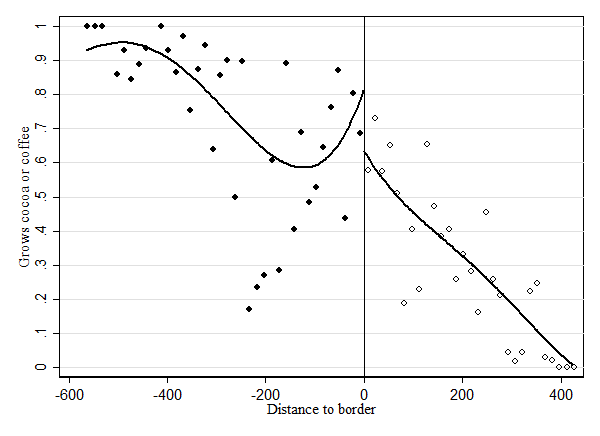


(file rdcocoaorcoffeeany12mos.pdf written in PDF format)
123.64514
174.78014
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =      1,580
Number of PSUs     =       136                  Population size   = 1,567.2446
                                                Design df         =        135
                                                F(   3,    133)   =       6.02
                                                Prob > F          =     0.0007
                                                R-squared         =     0.0438

------------------------------------------------------------------------------
             |             Linearized
cocoaorcof~s |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ghana |  -.1641203   .1011797    -1.62   0.107    -.3642227    .0359821
        dist |   .0013878 

In [24]:
foreach var of local depvars {

*	*eststo clear 
	preserve
	
	* create weighted means for each bin
	gen yweight = `var' * allwaitn

	* to create weighted averages in each bin using the CLSS survey weights, it is helpful 
	* to create the sum of weights in each bin to use to normalize weights.
	bysort distbin: egen binweightsum = sum(allwaitn) if `var' != .

	bysort distbin: egen yweightbinsum = sum(yweight)
	gen yweightbin = yweightbinsum / binweightsum

	* because of a quirk in which the obs with binmarker==1 is sometimes
	* missing the outcome variable, have to copy over the average for the bin into
	* all of the observations for that bin.
	bysort distbin: egen binavg = mean(yweightbin)

	* 4th-order polynomial
	svy: reg `var' ghana dist dist2 dist3 dist4 ghanadist ghanadist2 ghanadist3 ghanadist4
*	*eststo
	
	predict polyfit if e(sample), xb
	predict polystd if e(sample), stdp

	scalar tval = invttail(e(df_r), 0.975)

	gen polyfit_u = polyfit + tval*polystd
	gen polyfit_l = polyfit - tval*polystd

	sort dist

	twoway scatter binavg distbin if binmarker==1 & ghana == 0, mcolor(black) ///
    	|| scatter binavg distbin if binmarker==1 & ghana == 1, msymbol(Oh) mcolor(black) xline(0, lpattern(line) lcolor(black)) ///
    	|| line polyfit dist if ghana == 0 & clustmarker == 1,  lwidth(medthick) lcolor(black) ///
   		 || line polyfit dist if ghana == 1 & clustmarker == 1,  lwidth(medthick) lcolor(black) ///
	   	 xtitle("{stSerif:Distance to border}") ytitle( ``var'_title' ) ylabel(``var'_ticks', grid) ///
	   		legend(off) scheme(s1color) 

	graph export rd`var'.pdf, replace


	* local linear
	* optimal bandwidth
	rotbw `var' dist
	local hl = r(lbw)
	local hr = r(rbw)
	
	* local linear regressions
	
	display `hl'
	display `hr'
	svy: reg `var' ghana dist ghanadist  ///
    	 if dist >= -`hl' & dist <= `hr'
 *   *eststo
    
    display `hl'*2
	display `hr'*2

	svy: reg `var' ghana dist ghanadist ///
	 	 if dist >= -2*`hl' & dist <= 2*`hr'
*	*eststo
	
	display `hl'*0.5
	display `hr'*0.5
	svy: reg `var' ghana dist ghanadist  ///
     	 if dist >= -0.5*`hl' & dist <= 0.5*`hr'
*    *eststo
    
*   esttab using stateslawecon/tables/stateslawecon_tab_rdlat2.tex, label se ///
*                 nodepvars nomtitles title("Hello") booktabs ///
*    		     alignment(D{.}{.}{-1}) replace  
 	   	 
    restore

}


In [ ]:
* -----------------------------------------------
* ROBUSTNESS CHECK: COLLAPSE TO EA LEVEL
* -----------------------------------------------
* Instead of doing the RD analysis at the household
* level and clustering std errors at EA level, do the analysis
* at the EA level.  Also, for this exercise, discard weights.


use samplewithouttenantfarmers.dta, clear


collapse (mean) lat lon rightrentoutlandany rightselllandany  paidrentout fracfallow ///
		schhead readhead arithhead movedfromcighana migrant ///
		cocoaany12mos coffeeany12mos cocoaorcoffeeany12mos ///
		ghana dist, by(clust)

save ea_level.dta, replace

In [ ]:
		
* create higher order terms
gen dist2 = dist^2
gen dist3 = dist^3
gen dist4 = dist^4

* create interaction terms
gen ghanadist = ghana*dist
gen ghanadist2 = ghana*dist2
gen ghanadist3 = ghana*dist3
gen ghanadist4 = ghana*dist4

local depvars2 rightrentoutlandany paidrentout fracfallow rightselllandany  ///
		schhead readhead arithhead movedfromcighana migrant ///
		cocoaany12mos coffeeany12mos cocoaorcoffeeany12mos 

In [ ]:

foreach var of local depvars2 {

	* First, save a new dataset that drops observations where the dependent variable is missing
	preserve
	drop if `var' ==.
	
	* 4th-order polynomial
	reg `var' ghana dist dist2 dist3 dist4 ghanadist ghanadist2 ghanadist3 ghanadist4
	
	* local linear
	* optimal bandwidth
	rotbw `var' dist
	local hl = r(lbw)
	local hr = r(rbw)
	
	display `hl'
	display `hr'
	reg `var' ghana dist ghanadist  ///
    	 if dist >= -`hl' & dist <= `hr'
 *   *eststo
 	
	* local linear: bandwidth*2
    display `hl'*2
	display `hr'*2
	reg `var' ghana dist ghanadist ///
	 	 if dist >= -2*`hl' & dist <= 2*`hr'
*	*eststo

	* local linear: bandwidth*.5
	display `hl'*0.5
	display `hr'*0.5
	reg `var' ghana dist ghanadist  ///
     	 if dist >= -0.5*`hl' & dist <= 0.5*`hr'
	restore

	}

In [ ]:
* -----------------------------------------------
* ROBUSTNESS CHECK: Conley Std Errors
* -----------------------------------------------
* There might be spatial autocorrelation between observations
* To assess whether this autocorrelation is causing issues
* with the findings, we check whether the findings
* change when we use Conley Std Errors.


clear

use samplewithouttenantfarmers.dta

save conley_check.dta, replace



* For each dependent variable, we will calculate the mean for each

* enumeration area.  Then, we will run a regression discontinuity

* on each dependent variable at the EA level.



local depvars rightrentoutlandany paidrentout fracfallow rightselllandany

In [ ]:
* The CI data must be weighted, so we cannot simply take the average within each enumeration area

foreach var of local depvars {



* First, recalculate the dependent variables, giving the appropriate weight to each observation

* This new variable = weight * dependent variable

gen weighted_`var' = allwaitn*`var'



* Find the sum of the weighted dependent variable values within each enumeration area

bysort clust: egen num_`var' = total(weighted_`var')



* Sum the weights within each enumeration area (because they don't add up to 1)

bysort clust: egen den_`var' = total(allwaitn)



* Finally, calculate the weighted average.  It equals the sum of the weighted dep. var values / sum of the weights

gen wt_`var' = num_`var'/den_`var'

}


In [ ]:
* Now collapse to the EA level

collapse (mean) lat lon wt_rightrentoutlandany wt_rightselllandany wt_paidrentout wt_fracfallow ghana dist, by(clust)
* create higher order terms
gen dist2 = dist^2
gen dist3 = dist^3
gen dist4 = dist^4

* create interaction terms
gen ghanadist = ghana*dist
gen ghanadist2 = ghana*dist2
gen ghanadist3 = ghana*dist3
gen ghanadist4 = ghana*dist4

* We need to create cut-offs for the Conley spatial errors covariance matrix, as well as a constant term*
gen cutoff1 = 1
gen cutoff2 = 1
gen constant = 1

save conley_check.dta, replace

In [ ]:

local depvars wt_rightrentoutlandany wt_paidrentout wt_fracfallow wt_rightselllandany
foreach var of local depvars {

	use conley_check.dta, clear
	
	* The Conley program gets angry if any observations having a missing dependent variable
	* So, save a new dataset that drops observations where the dependent variable is missing
	save `var'_x_ols_reg.dta, replace
	drop if `var' ==.
	
	* 4th-order polynomial
	reg `var' ghana dist dist2 dist3 dist4 ghanadist ghanadist2 ghanadist3 ghanadist4
	
	* 4th-order polynomial with Conley std errors.  
	* Note: we want the same constant term from the normal regression, so set constant equal to _b[_cons]
	* replace constant = _b[_cons]
	x_ols lon lat cutoff1 cutoff2 `var' constant ghana dist dist2 dist3 dist4 ///
	ghanadist ghanadist2 ghanadist3 ghanadist4, xreg(10) coord(2)
	
	* Drop some of the variables that x_ols creates
	drop epsilon-dis2

	* Now do local linear regressions, with optimal bandwidth, bandwidth*.5, and bandwidth*2
	* Calculate optimal bandwidth
	rotbw `var' dist
	local hl = r(lbw)
	local hr = r(rbw)
	
	foreach num of numlist 1 .5 2 {
		reg `var' ghana dist ghanadist  ///
			 if dist >= -`hl'*`num' & dist <= `hr'*`num'
		* replace constant = _b[_cons]
	  
		* Same regression, but with Conley std errors
		preserve
		keep if dist >= -`hl'*`num' & dist <= `hr'*`num'
		x_ols lon lat cutoff1 cutoff2 `var' ghana dist ghanadist constant, xreg(4) coord(2)
		restore
		}
}



In [27]:



* --------------------------------------------e
* GHANA COCOA SUITABILITY ANALYSIS
* ------------------------------------------------

clear
insheet using EAs_climate.csv, comma
sort clust
* Our annual temperature data is in units of Celsius * 10--fix this
replace temp_annual = temp_annual / 10
save EAs_climate, replace

use analysissample.dta
keep if ghana==1
sort clust
save cocoa_suit_analysis.dta, replace

merge clust using EAs_climate.dta

* generate quadratic terms of our geographic and climatic controls
gen lat2 = lat * lat
gen lon2 = lon * lon
gen precip_annual2 = precip_annual * precip_annual
gen temp_annual2 = temp_annual * temp_annual


* First stage using region FEs and language
xi: svy: reg clustfraccocoaland cocoasuitindex i.region i.langhd if clustfraccocoa != . & rightrentoutlandany !=.


* First stage using region FEs, language and climactic vars
xi: svy: reg clustfraccocoaland cocoasuitindex i.region i.langhd precip_ann* temp_ann* if clustfraccocoa != . & rightrentoutlandany !=.





(12 vars, 461 obs)


variable temp_annual was int now float
(461 real changes made)

file EAs_climate.dta saved


(2,110 observations deleted)


file cocoa_suit_analysis.dta saved

(note: you are using old merge syntax; see [D] merge for new syntax)
variable clust does not uniquely identify observations in the master data
(note: variable name was str25, now str39 to accommodate using data's values)





i.region          _Iregion_1-10       (naturally coded; _Iregion_1 omitted)
i.langhd          _Ilanghd_2-8        (naturally coded; _Ilanghd_2 omitted)
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =      2,803
Number of PSUs     =       245                  Population size   =      2,803
                                                Design df         =        244
                                                F(  16,    229)   =      14.47
                                                Prob > F

In [28]:


* RIGHT RENT
*************
*OLS
xi: svy: reg rightrentoutlandany clustfraccocoaland i.region i.langhd if clustfraccocoa != . 
*Reduced form
xi: svy: reg rightrentoutlandany cocoasuitindex i.region i.langhd if clustfraccocoa != . 
* IV
xi: svy: ivreg rightrentoutlandany i.region i.langhd (clustfraccocoaland = cocoasuitindex)  if clustfraccocoa != . 


* RIGHT SELL
************
*OLS
xi: svy: reg rightselllandany clustfraccocoaland i.region i.langhd if clustfraccocoa != . 
*Reduced form
xi: svy: reg rightselllandany cocoasuitindex i.region i.langhd if clustfraccocoa != . 
* IV
xi: svy: ivreg rightselllandany i.region i.langhd (clustfraccocoaland = cocoasuitindex)  if clustfraccocoa != . 


* ---------------------------------------------------------------

* Region dummies, language, and climate controls

* RIGHT RENT
*************
*OLS
xi: svy: reg rightrentoutlandany clustfraccocoaland i.region precip_ann* temp_ann* i.langhd if clustfraccocoa != . 
*Reduced form
xi: svy: reg rightrentoutlandany cocoasuitindex i.region precip_ann* temp_ann* i.langhd if clustfraccocoa != . 
* IV
xi: svy: ivreg rightrentoutlandany i.region precip_ann* temp_ann*  (clustfraccocoaland = cocoasuitindex) i.langhd  if clustfraccocoa != . 


* RIGHT SELL
************
*OLS
xi: svy: reg rightselllandany clustfraccocoaland i.region precip_ann* temp_ann* i.langhd if clustfraccocoa != . 
*Reduced form
xi: svy: reg rightselllandany cocoasuitindex i.region precip_ann* temp_ann* i.langhd if clustfraccocoa != . 
* IV
xi: svy: ivreg rightselllandany i.region precip_ann* temp_ann* (clustfraccocoaland = cocoasuitindex) i.langhd if clustfraccocoa != . 





i.region          _Iregion_1-10       (naturally coded; _Iregion_1 omitted)
i.langhd          _Ilanghd_2-8        (naturally coded; _Ilanghd_2 omitted)
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =      2,803
Number of PSUs     =       245                  Population size   =      2,803
                                                Design df         =        244
                                                F(  16,    229)   =       7.59
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0824

------------------------------------------------------------------------------------
                   |             Linearized
rightrentoutland~y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------------+----------------------------------------------------------------
clustf

                                                Design df         =        239
                                                F(  16,    224)   =      28.44
                                                Prob > F          =     0.0000
                                                R-squared         =     0.1155

------------------------------------------------------------------------------------
                   |             Linearized
  rightselllandany |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------------+----------------------------------------------------------------
clustfraccocoaland |   .3345452   .1121691     2.98   0.003     .1135789    .5555116
        _Iregion_2 |   .1693873   .0469931     3.60   0.000     .0768137    .2619608
        _Iregion_3 |  -.1895688   .0342389    -5.54   0.000    -.2570173   -.1221203
        _Iregion_4 |   .0270575   .0547496     0.49   0.622    -.0807959    .1349109
        _Iregion_5 |  -.1198564   .0693122  

                   |             Linearized
rightrentoutland~y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------------+----------------------------------------------------------------
clustfraccocoaland |    .675007    .143973     4.69   0.000     .3914185    .9585956
        _Iregion_2 |   .1686379   .0541819     3.11   0.002     .0619139    .2753619
        _Iregion_3 |  -.1987868   .0472727    -4.21   0.000    -.2919015   -.1056721
        _Iregion_4 |   .0865824   .0642472     1.35   0.179    -.0399675    .2131323
        _Iregion_5 |  -.0640965   .1123497    -0.57   0.569    -.2853956    .1572025
        _Iregion_6 |  -.0084032   .0808689    -0.10   0.917    -.1676933    .1508869
        _Iregion_7 |   .1368592   .1148596     1.19   0.235    -.0893836     .363102
        _Iregion_8 |   .0816069   .0845785     0.96   0.336    -.0849902    .2482039
        _Iregion_9 |  -.0507586   .0639733    -0.79   0.428    -.1767689    .0752517
       _Iregion_10 | 

i.langhd          _Ilanghd_2-8        (naturally coded; _Ilanghd_2 omitted)
(running regress on estimation sample)

Survey: Linear regression

Number of strata   =         1                  Number of obs     =      2,705
Number of PSUs     =       240                  Population size   =      2,705
                                                Design df         =        239
                                                F(  19,    221)   =          .
                                                Prob > F          =          .
                                                R-squared         =     0.1201

------------------------------------------------------------------------------------
                   |             Linearized
  rightselllandany |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------------+----------------------------------------------------------------
clustfraccocoaland |   .3544644   .1185088     2.99   0.003     .1210093    .587919

             _cons |   2.080029   .7078329     2.94   0.004     .6856412    3.474417
------------------------------------------------------------------------------------
Instrumented:  clustfraccocoaland
Instruments:   _Iregion_2 _Iregion_3 _Iregion_4 _Iregion_5 _Iregion_6 _Iregion_7
               _Iregion_8 _Iregion_9 _Iregion_10 precip_annual precip_annual2
               temp_annual temp_annual2 _Ilanghd_3 _Ilanghd_4 _Ilanghd_5
               _Ilanghd_6 _Ilanghd_7 _Ilanghd_8 cocoasuitindex
------------------------------------------------------------------------------------
